# Final project - Animal classification

### Authors:
* **Yair Turgeman**
* **Elad Laster**

 In this notebook we will work on the Animal Classification project, we have 15,000 pictures of mammals and our goal is to let the model train on 90% of them (train), and try to get the highest percentage of accuracy in the remaining 10% (test).
 
 during our work we will have to loading the pictures in our data, turn them into pixel data, we will try a variety of models and look for the best, then we will get lower our amount of dimensions with PCA ,
then we will try again a variety of models and look for the best, all of this using a variety of functions and hyper-parameters That will help us achieve the best model 
#### Enjoy your reading!


## 

# Imports & Work on the data

In [ ]:
#pip install pandas numpy matplotlib opencv-python-headless scikit-learn pillow seaborn tensorflow

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
import seaborn as sns
from seaborn import color_palette
from sklearn.manifold import TSNE
# from tensorflow.keras.utils import img_to_array
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
import warnings
from IPython.display import display, Image
import requests
import tarfile
import random
warnings.filterwarnings('ignore')

## Auxiliary functions

In [2]:
# converting the image to gray scale
def rgb2gray(df):
    return np.dot(df[...,:3], [0.2989, 0.5870, 0.1140])
# Function to resize images
def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size)
    return resized_image

# Function to normalize images using mean and standard deviation
def normalize_images(images):
    normalized_images = images/255.0
    return normalized_images

In [3]:
def preprocessing(animals, folders, general_folder_path):
    dic ={}
    count= 0
    for  index, animal in enumerate(animals):
        dic[index] = animal
        for folder in folders:
            folder_path = os.path.join(general_folder_path, folder ,animal)
            for filename in os.listdir(folder_path):
                count+=1
                img_path = os.path.join(folder_path, filename)
            print(  f"{index}  {animal}" , end= " : ")
            print(folder_path) 
    print(f"all images = {count}")
    print(dic)

In [4]:
def preprocessingimg(animals, folders, general_folder_path ,size):
    dic ={}
    all_images_temp = []
    all_labels =[]
    for index, animal in enumerate(animals):
        dic[index] = animal
        for folder in folders:
            folder_path = os.path.join(general_folder_path, folder ,animal)
            # Load and resize all images to labels
            images = []
            labels = []
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = resize_image(img, (size, size))  # Resize image to a common size
                    images.append(img.flatten())
                    labels.append(index)  # Assigning labels
            print(f"{index}  {animal}"  , end= " : ")
            print(folder_path)
            # Union all the images and labels
            all_images_temp += (images)
            all_labels += (labels)
    all_images_temp = np.array(all_images_temp)
    all_labels = np.array(all_labels)
    return all_images_temp ,all_labels , dic

### Data to dataframe

In [5]:
# Path to the general folder
general_folder_path = 'C:\\Users\\yairt\\Desktop\\ML\\ML\\project\\mammal\\Animal\\'
# general_folder_path = 'Animal\\'

# Path to 5 directories
animals = ['cat', 'dog', 'ELEPHANT', 'HORSE', 'LION']
folders = ['train', 'val']
folder_train = ['train']
folder_val = ['val']

preprocessing(animals, folder_train, general_folder_path)
# preprocessing(animals, folder_val, general_folder_path)

0  cat : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\cat
1  dog : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\dog
2  ELEPHANT : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\ELEPHANT
3  HORSE : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\HORSE
4  LION : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\LION
all images = 13497
{0: 'cat', 1: 'dog', 2: 'ELEPHANT', 3: 'HORSE', 4: 'LION'}


##  Train Test - split & shuffle & resize

In [6]:
x_train , y_train , dic_animals = preprocessingimg(animals, folder_train , general_folder_path ,32)

0  cat : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\cat
1  dog : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\dog
2  ELEPHANT : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\ELEPHANT
3  HORSE : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\HORSE
4  LION : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\train\LION


In [7]:
x_test , y_test , dic_animals = preprocessingimg(animals, folder_val , general_folder_path ,32)

0  cat : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\val\cat
1  dog : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\val\dog
2  ELEPHANT : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\val\ELEPHANT
3  HORSE : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\val\HORSE
4  LION : C:\Users\yairt\Desktop\ML\ML\project\mammal\Animal\val\LION


In [13]:
x_train

array([[ 22,  26,  27, ...,  90, 138, 169],
       [157, 163, 169, ..., 238, 241, 245],
       [ 80, 108, 125, ..., 107, 136, 170],
       ...,
       [ 31,  31,  20, ...,  35,  19,   9],
       [ 30,  32,  23, ...,  72,  72,  58],
       [ 36, 157, 227, ...,  36,  57,  65]], dtype=uint8)

In [14]:
x_train.shape , y_train ,y_train.shape

((13496, 3072), array([0, 0, 0, ..., 4, 4, 4]), (13496,))

In [15]:
x_test

array([[  6,  32, 122, ..., 110, 144, 189],
       [146, 115, 100, ..., 186, 183, 198],
       [ 53,  74,  75, ...,  27, 134, 127],
       ...,
       [239, 228, 224, ...,  43, 102, 103],
       [238, 242, 243, ..., 151, 200, 239],
       [221, 215, 219, ...,  40,  36,  55]], dtype=uint8)

In [16]:
x_test.shape , y_test , y_test.shape

((1500, 3072), array([0, 0, 0, ..., 4, 4, 4]), (1500,))

## Let's see few picture from the data

Showing 5 images for cat:


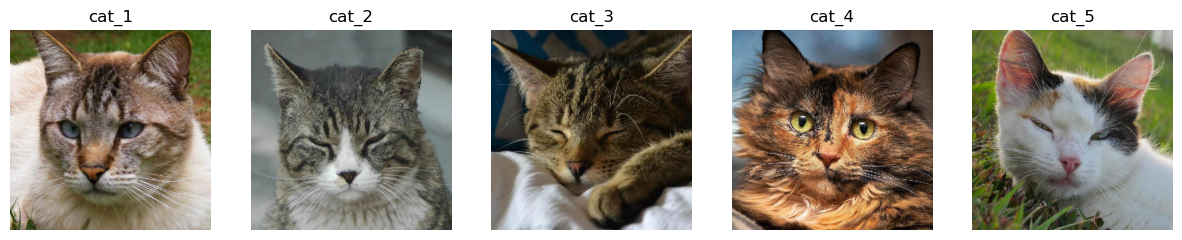

Showing 5 images for dog:


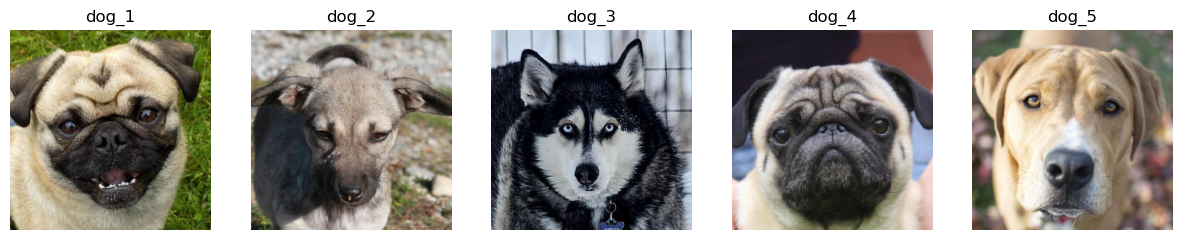

Showing 5 images for ELEPHANT:


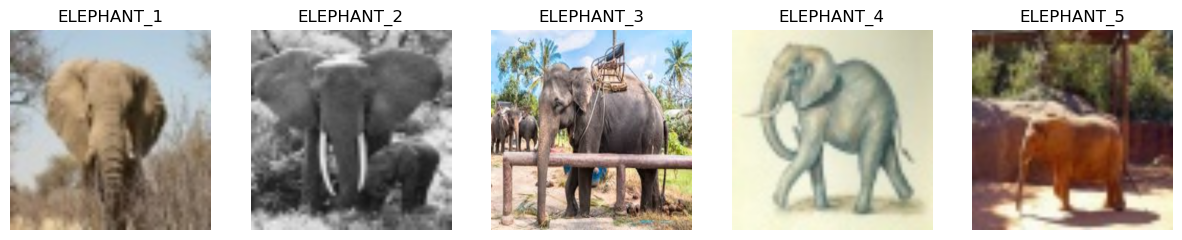

Showing 5 images for HORSE:


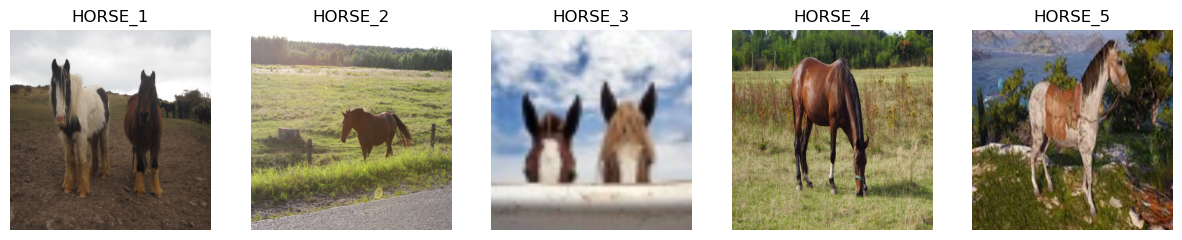

Showing 5 images for LION:


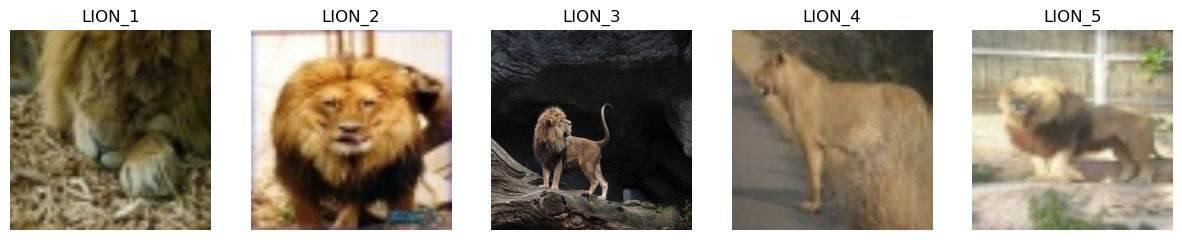

In [9]:
# Function to show images
def show_images(images, titles):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def display_sample_images(dic_animals, all_labels, all_images_temp):
    # Initialize dictionary to store images for each category
    sample_images = {animal: [] for animal in dic_animals.values()}

    # Populate sample_images dictionary with 5 random images for each category
    for label in range(len(dic_animals)):
        animal_name = dic_animals[label]
        indices = np.where(all_labels == label)[0]
        selected_indices = random.sample(indices.tolist(), min(5, len(indices)))
        for index in selected_indices:
            sample_images[animal_name].append(all_images_temp[index].reshape(512, 512, 3))

    # Display 5 images for each category
    for animal, images in sample_images.items():
        print(f"Showing 5 images for {animal}:")
        show_images(images[:5], [f"{animal}_{i}" for i in range(1, 6)])

# Example usage:
# Assuming dic_animals, all_labels, and all_images_temp are defined elsewhere
display_sample_images(dic_animals, y_train, x_train)

## Insert the data to table

In [8]:
df_images = pd.DataFrame(x_train)
df_images['label']= y_train.T
df_combined = df_images
df_combined

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,22,26,27,20,25,24,23,25,25,20,...,56,88,110,85,128,155,90,138,169,0
1,157,163,169,159,163,169,160,164,169,159,...,243,248,247,242,246,247,238,241,245,0
2,80,108,125,83,112,127,86,117,130,69,...,2,4,6,61,75,100,107,136,170,0
3,43,69,46,48,76,53,48,76,53,45,...,247,241,238,253,244,240,253,244,240,0
4,210,204,209,210,204,207,209,201,204,206,...,24,37,44,22,35,43,44,54,64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13491,26,81,53,30,86,55,31,88,54,39,...,152,171,186,151,170,185,157,176,191,4
13492,81,90,110,75,84,104,69,78,98,70,...,118,139,178,117,138,176,110,132,168,4
13493,31,31,20,42,30,31,30,29,29,23,...,45,11,0,38,12,0,35,19,9,4
13494,30,32,23,34,34,25,38,36,28,44,...,73,65,55,78,71,58,72,72,58,4


In [9]:
df_combined_shaffeled = df_combined.sample(frac=1)
df_combined_shaffeled.head(20)

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
8302,71,77,84,79,85,92,84,92,99,91,...,76,82,89,75,81,88,71,79,86,3
11701,128,104,97,132,108,102,135,111,105,138,...,20,55,83,14,49,77,22,57,86,4
835,58,46,34,61,49,37,59,47,35,60,...,56,56,62,78,76,83,71,71,77,0
4343,43,104,84,42,106,77,23,87,57,56,...,223,200,184,228,209,192,234,211,195,1
11318,41,88,55,52,97,62,17,53,13,1,...,100,132,168,120,154,197,105,142,190,4
11515,22,64,108,29,71,122,29,76,122,24,...,22,51,97,16,49,86,39,72,118,4
9695,42,48,48,47,52,55,48,52,57,51,...,78,79,77,32,30,29,16,16,13,3
10036,255,255,255,255,255,255,255,255,255,255,...,49,172,133,70,187,156,24,54,57,3
6604,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2
10363,58,85,82,58,85,81,65,92,88,75,...,131,172,197,119,159,187,118,158,186,3


In [10]:
y_train_s = df_combined_shaffeled['label']
y_train_s

8302     3
11701    4
835      0
4343     1
11318    4
        ..
40       0
11815    4
2461     0
1104     0
12601    4
Name: label, Length: 13496, dtype: int32

In [11]:
x_train_s = df_combined_shaffeled.drop(["label"], axis=1 )
x_train_s

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
8302,71,77,84,79,85,92,84,92,99,91,...,94,76,82,89,75,81,88,71,79,86
11701,128,104,97,132,108,102,135,111,105,138,...,74,20,55,83,14,49,77,22,57,86
835,58,46,34,61,49,37,59,47,35,60,...,57,56,56,62,78,76,83,71,71,77
4343,43,104,84,42,106,77,23,87,57,56,...,116,223,200,184,228,209,192,234,211,195
11318,41,88,55,52,97,62,17,53,13,1,...,115,100,132,168,120,154,197,105,142,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,33,41,44,57,65,71,68,78,84,81,...,170,187,173,167,184,171,164,180,167,158
11815,179,163,157,182,166,160,181,167,161,183,...,76,12,34,56,38,63,81,22,45,56
2461,158,159,157,179,180,178,162,163,161,178,...,119,111,116,115,104,109,108,65,70,69
1104,101,90,70,89,78,50,78,63,27,82,...,195,33,1,177,30,5,192,31,2,162


In [12]:
x_train_s_n = normalize_images(x_train_s)
x_train_s_n

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
8302,0.278431,0.301961,0.329412,0.309804,0.333333,0.360784,0.329412,0.360784,0.388235,0.356863,...,0.368627,0.298039,0.321569,0.349020,0.294118,0.317647,0.345098,0.278431,0.309804,0.337255
11701,0.501961,0.407843,0.380392,0.517647,0.423529,0.400000,0.529412,0.435294,0.411765,0.541176,...,0.290196,0.078431,0.215686,0.325490,0.054902,0.192157,0.301961,0.086275,0.223529,0.337255
835,0.227451,0.180392,0.133333,0.239216,0.192157,0.145098,0.231373,0.184314,0.137255,0.235294,...,0.223529,0.219608,0.219608,0.243137,0.305882,0.298039,0.325490,0.278431,0.278431,0.301961
4343,0.168627,0.407843,0.329412,0.164706,0.415686,0.301961,0.090196,0.341176,0.223529,0.219608,...,0.454902,0.874510,0.784314,0.721569,0.894118,0.819608,0.752941,0.917647,0.827451,0.764706
11318,0.160784,0.345098,0.215686,0.203922,0.380392,0.243137,0.066667,0.207843,0.050980,0.003922,...,0.450980,0.392157,0.517647,0.658824,0.470588,0.603922,0.772549,0.411765,0.556863,0.745098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0.129412,0.160784,0.172549,0.223529,0.254902,0.278431,0.266667,0.305882,0.329412,0.317647,...,0.666667,0.733333,0.678431,0.654902,0.721569,0.670588,0.643137,0.705882,0.654902,0.619608
11815,0.701961,0.639216,0.615686,0.713725,0.650980,0.627451,0.709804,0.654902,0.631373,0.717647,...,0.298039,0.047059,0.133333,0.219608,0.149020,0.247059,0.317647,0.086275,0.176471,0.219608
2461,0.619608,0.623529,0.615686,0.701961,0.705882,0.698039,0.635294,0.639216,0.631373,0.698039,...,0.466667,0.435294,0.454902,0.450980,0.407843,0.427451,0.423529,0.254902,0.274510,0.270588
1104,0.396078,0.352941,0.274510,0.349020,0.305882,0.196078,0.305882,0.247059,0.105882,0.321569,...,0.764706,0.129412,0.003922,0.694118,0.117647,0.019608,0.752941,0.121569,0.007843,0.635294


In [13]:
x_test_n = normalize_images(x_test)
x_test_n

array([[0.02352941, 0.1254902 , 0.47843137, ..., 0.43137255, 0.56470588,
        0.74117647],
       [0.57254902, 0.45098039, 0.39215686, ..., 0.72941176, 0.71764706,
        0.77647059],
       [0.20784314, 0.29019608, 0.29411765, ..., 0.10588235, 0.5254902 ,
        0.49803922],
       ...,
       [0.9372549 , 0.89411765, 0.87843137, ..., 0.16862745, 0.4       ,
        0.40392157],
       [0.93333333, 0.94901961, 0.95294118, ..., 0.59215686, 0.78431373,
        0.9372549 ],
       [0.86666667, 0.84313725, 0.85882353, ..., 0.15686275, 0.14117647,
        0.21568627]])

# Data Distribution

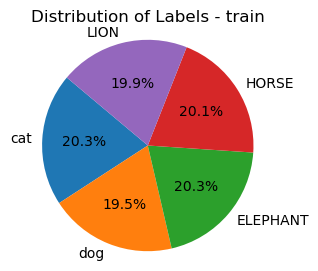

----------------------------------------


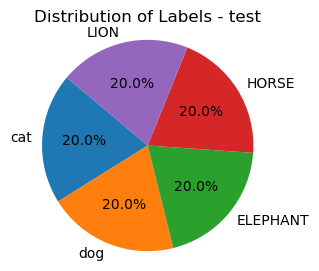

In [25]:
def plot_label_distribution(y , title):
    # Count occurrences of each label
    unique_labels, label_counts = np.unique(y, return_counts=True)
    # Map labels to their corresponding names
    labels = {0: 'cat', 1: 'dog', 2: 'ELEPHANT', 3: 'HORSE', 4: 'LION'}
    
    # Create pie chart
    plt.figure(figsize=(3, 3))
    plt.pie(label_counts, labels=[labels[label] for label in unique_labels], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()
    
    
# Assuming you already have 'y' defined
plot_label_distribution(y_train_s , 'Distribution of Labels - train')
print("-"*40)
plot_label_distribution(y_test ,'Distribution of Labels - test');

# Models

## KNN - model

In [39]:
def train_and_validate_knn(x_train, y_train, x_val, y_val, k_values):
    best_accuracy = 0
    best_model = None
    best_k = None
    y_val_pred_final = None
    train_scores = []
    test_scores = []
    x_train = np.array(x_train)
    for k in k_values:
        # Train the kNN model
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(x_train, y_train)
        
        # Predictions
        model_knn_pred_val = knn_model.predict(x_val)
        model_knn_pred_train = knn_model.predict(x_train)
        
        # Accuracy of Model 
        acc_knn_val = accuracy_score(y_val, model_knn_pred_val)
        acc_knn_train = accuracy_score(y_train, model_knn_pred_train)
        
        # Update the training scores list
        train_scores.append(acc_knn_train)
    
        # Update the test scores list
        test_scores.append(acc_knn_val)
        
        print(f"{k} = K: Validation set - Accuracy: {acc_knn_val:.3f}, Training set - Accuracy: {acc_knn_train:.3f}")
        
        # Check if current model is better than the previous best
        if acc_knn_val > best_accuracy:
            best_accuracy = acc_knn_val
            best_k = k
            best_model = knn_model
            y_val_pred_final = model_knn_pred_val
            
    plt.plot(range(1, 10), train_scores, label="Train score")
    plt.plot(range(1, 10), test_scores, label="Test score")
    plt.xticks(np.arange(1, 10))
    plt.xlabel("best k ")
    plt.ylabel("Model score")
    plt.legend()

    print(f"best k score on the test data: {max(test_scores)*100:.2f}%")
    # Print and return the best model's evaluation
    print("\nBest Model (based on Validation Accuracy):")
    print(f"best k: {best_k}")
    
    return best_k, best_accuracy ,y_val_pred_final

1 = K: Validation set - Accuracy: 0.421, Training set - Accuracy: 1.000
2 = K: Validation set - Accuracy: 0.450, Training set - Accuracy: 0.835
3 = K: Validation set - Accuracy: 0.420, Training set - Accuracy: 0.658
4 = K: Validation set - Accuracy: 0.433, Training set - Accuracy: 0.610
5 = K: Validation set - Accuracy: 0.427, Training set - Accuracy: 0.564
6 = K: Validation set - Accuracy: 0.416, Training set - Accuracy: 0.540
7 = K: Validation set - Accuracy: 0.411, Training set - Accuracy: 0.515
8 = K: Validation set - Accuracy: 0.408, Training set - Accuracy: 0.504
9 = K: Validation set - Accuracy: 0.404, Training set - Accuracy: 0.483
best k score on the test data: 45.00%

Best Model (based on Validation Accuracy):
best k: 2
Best k: 2, Best Validation Accuracy: 0.45


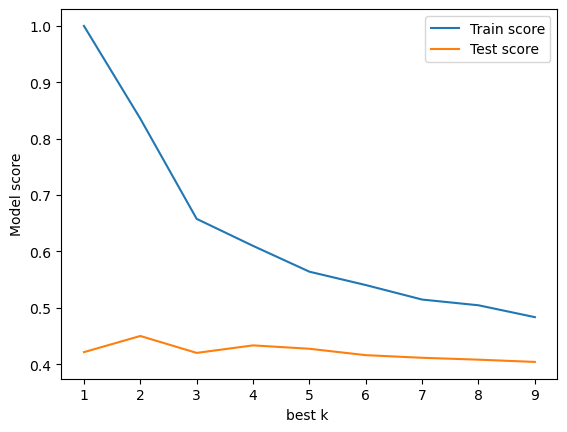

In [40]:
# Example usage
k_values = range(1, 10)  # Example range of k values
best_k_knn, best_accuracy_knn , y_val_pred_knn = train_and_validate_knn(x_train_s_n, y_train_s, x_test_n, y_test, k_values)
print(f"Best k: {best_k_knn}, Best Validation Accuracy: {best_accuracy_knn}")

### Confusion matrix

In [41]:
def plot_confusion_mat(matrix,class_names):
    conf_matrix = pd.DataFrame(data=matrix,index=class_names, columns=class_names)
    plt.figure(figsize = (8,5))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, fmt = "g")

In [42]:
y_val_pred_knn

array([0, 0, 0, ..., 4, 4, 4])

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       300
           1       0.73      0.35      0.47       300
           2       0.35      0.67      0.46       300
           3       0.50      0.18      0.26       300
           4       0.41      0.56      0.47       300

    accuracy                           0.45      1500
   macro avg       0.51      0.45      0.44      1500
weighted avg       0.51      0.45      0.44      1500



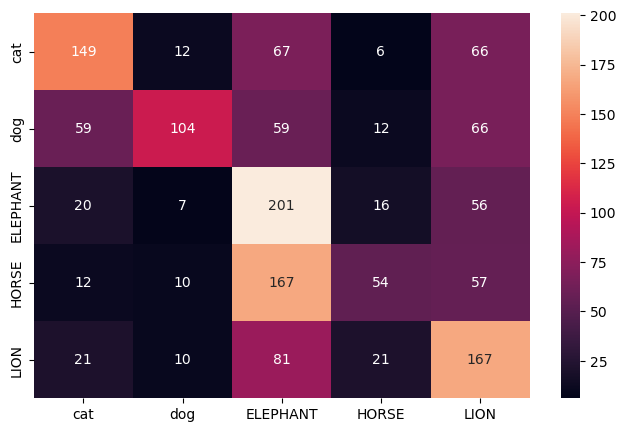

In [43]:
confmat_knn = confusion_matrix(y_test, y_val_pred_knn)
print(classification_report(y_test, y_val_pred_knn))
plot_confusion_mat(confmat_knn,animals)

## LogisticRegression - model

In [44]:
def LR(train, val, y_train, y_val):
    best_accuracy = 0
    best_model = None
    best_iter = None
    y_val_pred_final = None
    train_scores = []
    test_scores = []
    
    for i in range(20, 261, 20):
        model_lr = LogisticRegression(max_iter=i)
        model_lr.fit(train, y_train)
        
        # Predictions
        model_lr_pred_val = model_lr.predict(val)
        model_lr_pred_train = model_lr.predict(train)
        
        # Accuracy of Model 
        acc_lr_val = accuracy_score(y_val, model_lr_pred_val)
        acc_lr_train = accuracy_score(y_train, model_lr_pred_train)
        
        # Update the training scores list
        train_scores.append(acc_lr_train)
    
        # Update the test scores list
        test_scores.append(acc_lr_val)
        
        print(f"{i} iterations: Validation set - Accuracy: {acc_lr_val:.3f}, Training set - Accuracy: {acc_lr_train:.3f}")
        
        # Check if current model is the best
        if acc_lr_val > best_accuracy:
            best_accuracy = acc_lr_val
            best_model = model_lr
            best_iter = i
            y_val_pred_final = model_lr_pred_val
    
    
    plt.plot(range(20, 261, 20), train_scores, label="Train score")
    plt.plot(range(20, 261, 20), test_scores, label="Test score")
    plt.xticks(np.arange(20, 261, 20))
    plt.xlabel("Max Iterations")
    plt.ylabel("Model score")
    plt.legend()

    print(f"Max Iterations score on the test data: {max(test_scores)*100:.2f}%")
    # Print and return the best model's evaluation
    print("\nBest Model (based on Validation Accuracy):")
    print(f"Max Iterations: {best_iter}")

    return best_model ,y_val_pred_final


20 iterations: Validation set - Accuracy: 0.497, Training set - Accuracy: 0.517
40 iterations: Validation set - Accuracy: 0.547, Training set - Accuracy: 0.564
60 iterations: Validation set - Accuracy: 0.560, Training set - Accuracy: 0.592
80 iterations: Validation set - Accuracy: 0.587, Training set - Accuracy: 0.618
100 iterations: Validation set - Accuracy: 0.588, Training set - Accuracy: 0.639
120 iterations: Validation set - Accuracy: 0.590, Training set - Accuracy: 0.654
140 iterations: Validation set - Accuracy: 0.599, Training set - Accuracy: 0.665
160 iterations: Validation set - Accuracy: 0.599, Training set - Accuracy: 0.680
180 iterations: Validation set - Accuracy: 0.596, Training set - Accuracy: 0.686
200 iterations: Validation set - Accuracy: 0.589, Training set - Accuracy: 0.695
220 iterations: Validation set - Accuracy: 0.579, Training set - Accuracy: 0.699
240 iterations: Validation set - Accuracy: 0.582, Training set - Accuracy: 0.704
260 iterations: Validation set -

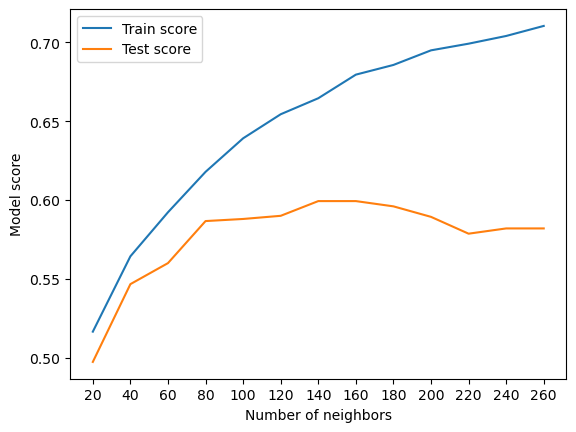

In [45]:
# Usage
best_lr_model_n , y_pred_LR_n = LR(x_train_s_n, x_test_n, y_train_s, y_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.67      0.68      0.68       300
           1       0.77      0.72      0.74       300
           2       0.46      0.50      0.48       300
           3       0.53      0.46      0.49       300
           4       0.58      0.63      0.61       300

    accuracy                           0.60      1500
   macro avg       0.60      0.60      0.60      1500
weighted avg       0.60      0.60      0.60      1500



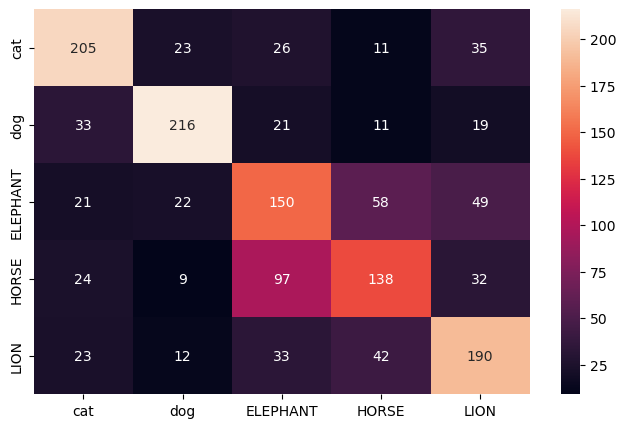

In [46]:
confmat_lr = confusion_matrix(y_test, y_pred_LR_n)
print(classification_report(y_test, y_pred_LR_n))
plot_confusion_mat(confmat_lr,animals)

## DecisionTree - model

In [63]:
def Decision_tree(train,val,y_train,y_val):
    best_accuracy = 0
    best_model = None
    best_iter = None
    y_val_pred_final = None
    train_scores = []
    test_scores = []
    
    for i in range(2, 14, 2):
        d_tree = DecisionTreeClassifier(max_depth = i)    
        d_tree.fit(train,y_train)
        
        # Predictions
        d_tree_pred_val = d_tree.predict(val)
        d_tree_pred_train = d_tree.predict(train)
        
        # Accuracy of Model 
        acc_d_tree_val = accuracy_score(y_val, d_tree_pred_val)
        acc_d_tree_train = accuracy_score(y_train, d_tree_pred_train)
        
        # Update the training scores list
        train_scores.append(acc_d_tree_train)
    
        # Update the test scores list
        test_scores.append(acc_d_tree_val)
        
        print(f"{i} iterations: Validation set - Accuracy: {acc_d_tree_val:.3f}, Training set - Accuracy: {acc_d_tree_train:.3f}")
        
        # Check if current model is the best
        if acc_d_tree_val > best_accuracy:
            best_accuracy = acc_d_tree_val
            best_model = d_tree
            best_iter = i
            y_val_pred_final = d_tree_pred_val
    
    
    plt.plot(range(2, 14, 2), train_scores, label="Train score")
    plt.plot(range(2, 14, 2), test_scores, label="Test score")
    plt.xticks(np.arange(2, 14, 2))
    plt.xlabel("Number of max_depth")
    plt.ylabel("Model score")
    plt.legend()

    print(f"max_depth score on the test data: {max(test_scores)*100:.2f}%")
    # Print and return the best model's evaluation
    print("\nBest Model (based on Validation Accuracy):")
    print(f"max_depth: {best_iter}")

    return best_model ,y_val_pred_final
    



2 iterations: Validation set - Accuracy: 0.302, Training set - Accuracy: 0.308
4 iterations: Validation set - Accuracy: 0.362, Training set - Accuracy: 0.388
6 iterations: Validation set - Accuracy: 0.397, Training set - Accuracy: 0.465
8 iterations: Validation set - Accuracy: 0.413, Training set - Accuracy: 0.551
10 iterations: Validation set - Accuracy: 0.427, Training set - Accuracy: 0.659
12 iterations: Validation set - Accuracy: 0.411, Training set - Accuracy: 0.761
max_depth score on the test data: 42.67%

Best Model (based on Validation Accuracy):
max_depth: 10


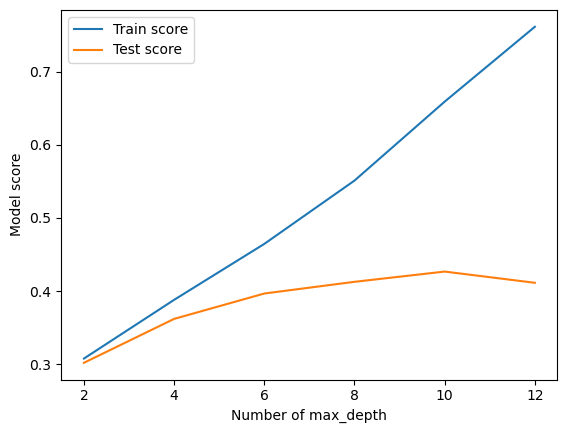

In [64]:
best_model ,model_dt_pred = Decision_tree(x_train,x_test,y_train,y_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       300
           1       0.56      0.35      0.43       300
           2       0.37      0.47      0.41       300
           3       0.38      0.25      0.30       300
           4       0.41      0.59      0.48       300

    accuracy                           0.43      1500
   macro avg       0.44      0.43      0.42      1500
weighted avg       0.44      0.43      0.42      1500



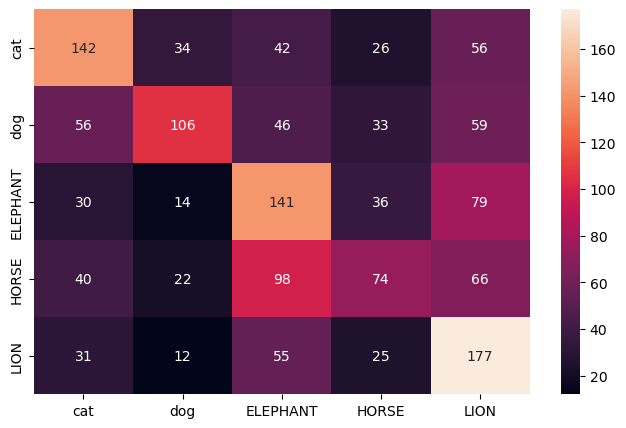

In [65]:
confmat_lr = confusion_matrix(y_test, model_dt_pred)
plot_confusion_mat(confmat_lr,animals)

print(classification_report(y_test, model_dt_pred))

## ADABOOST - model

In [119]:

def train_and_predict_adaboost(x_train, y_train, x_test, y_test):
    best_accuracy = 0
    best_n_estimators = 0
    
    for n_estimators in range(10, 201, 10):
        # Initialize AdaBoost classifier
        adaboost_clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.0)
        
        # Train the AdaBoost classifier
        adaboost_clf.fit(x_train, y_train)
        
        # Predict on the test data
        y_pred = adaboost_clf.predict(x_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Check if this model has better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_estimators = n_estimators
            
        print("Accuracy for n_estimators =", n_estimators, "is:", accuracy)
    
    print("The best Accuracy score for ADABOOST Model is:", best_accuracy, "achieved with n_estimators =", best_n_estimators)
    
    return best_n_estimators , y_pred

In [80]:
# Assuming you have your data (x_train, y_train, x_test, y_test) ready
best_n_estimators , y_pred_adaboost = train_and_predict_adaboost(x_train, y_train, x_test, y_test)


Accuracy for n_estimators = 10 is: 0.39066666666666666
Accuracy for n_estimators = 20 is: 0.4166666666666667
Accuracy for n_estimators = 30 is: 0.4613333333333333
Accuracy for n_estimators = 40 is: 0.4633333333333333
Accuracy for n_estimators = 50 is: 0.48533333333333334
Accuracy for n_estimators = 60 is: 0.498
Accuracy for n_estimators = 70 is: 0.5
Accuracy for n_estimators = 80 is: 0.5206666666666667
Accuracy for n_estimators = 90 is: 0.51
Accuracy for n_estimators = 100 is: 0.5226666666666666
Accuracy for n_estimators = 110 is: 0.5193333333333333
Accuracy for n_estimators = 120 is: 0.5213333333333333
Accuracy for n_estimators = 130 is: 0.5193333333333333
Accuracy for n_estimators = 140 is: 0.5266666666666666
Accuracy for n_estimators = 150 is: 0.5266666666666666
Accuracy for n_estimators = 160 is: 0.528
Accuracy for n_estimators = 170 is: 0.5353333333333333
Accuracy for n_estimators = 180 is: 0.536
Accuracy for n_estimators = 190 is: 0.542
Accuracy for n_estimators = 200 is: 0.544
T

In [ ]:
y_pred = train_and_predict_adaboost#(x_train, y_train, x_test, y_test)

### Confusion matrix

              precision    recall  f1-score   support

         cat       0.52      0.47      0.49       300
         dog       0.57      0.58      0.57       300
    ELEPHANT       0.40      0.48      0.44       300
       HORSE       0.52      0.40      0.45       300
        LION       0.45      0.50      0.48       300

    accuracy                           0.49      1500
   macro avg       0.49      0.49      0.49      1500
weighted avg       0.49      0.49      0.49      1500



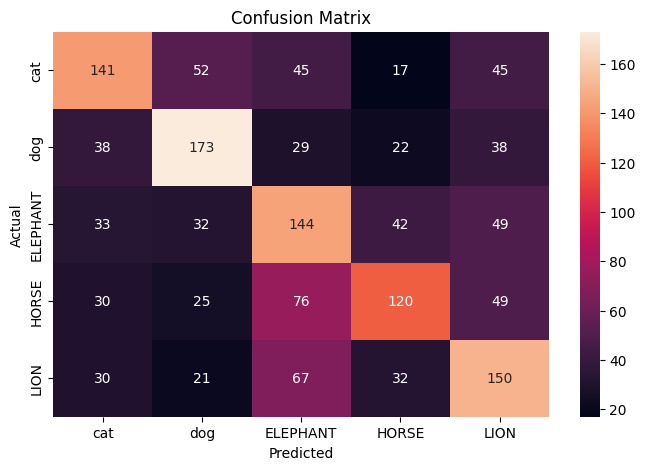

In [100]:
confmat_adaboost = confusion_matrix(y_test, y_pred)

# Define function to plot confusion matrix
def plot_confusion_mat(matrix, class_names):
    conf_matrix = pd.DataFrame(data=matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 5))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt="g")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

# Plot confusion matrix
plot_confusion_mat(confmat_adaboost, animals)

# Print classification report
print(classification_report(y_test, y_pred, target_names=animals))

## Moving to grayscale

In [92]:
def convert_to_grayscale(images, size):
    gray_images = []
    for img_flat in images:
        img = img_flat.reshape(size, size, -1)  # Reshape to original image shape
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        gray_images.append(gray_img.flatten())  # Flatten grayscale image
    return np.array(gray_images)

# Convert x_train to grayscale images
x_train_gray = convert_to_grayscale(x_train_s.values, size=32)
x_test_gray = convert_to_grayscale(x_test, size=32)


In [93]:
x_train_gray

array([[107, 115, 116, ...,  73,  74,  35],
       [ 76,  76,  95, ..., 175, 182, 200],
       [  0,   0,   0, ..., 184, 183,  64],
       ...,
       [ 25,  84,  91, ..., 126,  81,  63],
       [241, 240, 245, ..., 178, 188, 178],
       [255, 255, 255, ..., 202, 212, 217]], dtype=uint8)

In [94]:
x_test_gray

array([[ 56,  52,  44, ..., 199, 176, 154],
       [114, 111, 112, ..., 179, 186, 188],
       [ 72,  34,  44, ..., 122,  77, 120],
       ...,
       [228, 230, 228, ...,  92,  94,  96],
       [242, 242, 242, ..., 194, 210, 206],
       [217, 142, 100, ..., 154,  40,  42]], dtype=uint8)

In [95]:
x_train_gray.shape , x_test_gray.shape

((13496, 1024), (1500, 1024))

## Let's see few picture from the data

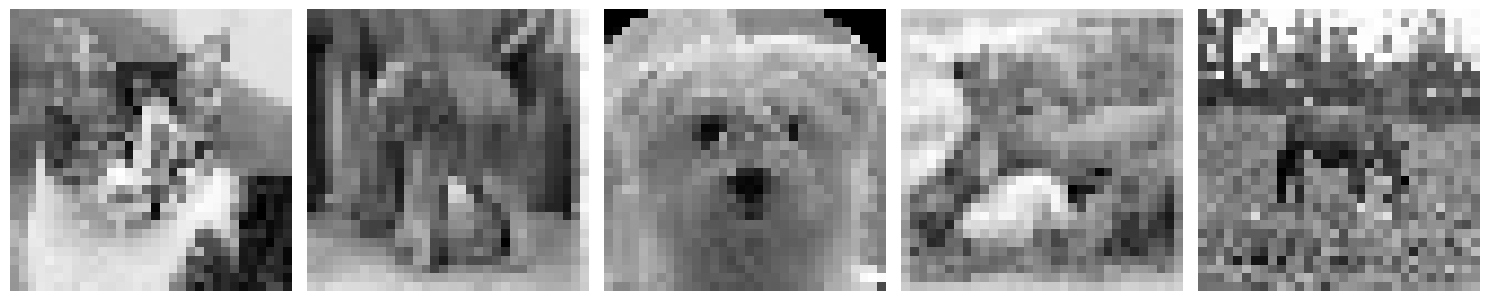

In [86]:
def show_random_gray_images(images, num_images=5):
    num_total_images = len(images)
    indices = np.random.choice(num_total_images, num_images, replace=False)
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        image_reshaped = images[i].reshape(32, 32)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_reshaped, cmap='gray')  # Display grayscale image
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming x_train_gray, x_val_gray, and x_test_gray contain your grayscale images
show_random_gray_images(x_train_gray, num_images=5)


# models

## KNN - model

In [96]:
# Example usage
k_values = range(1, 11)  # Example range of k values
best_k_knn_g, best_accuracy_knn_g , y_val_pred_final_knn_g = train_and_validate_knn(x_train_gray, y_train_s, x_test_gray, y_test, k_values)
print(f"Best k: {best_k_knn_g}, Best Validation Accuracy: {best_accuracy_knn_g}")

Validation Accuracy for k=1: 0.4026666666666667
Validation Accuracy for k=2: 0.43133333333333335
Validation Accuracy for k=3: 0.4126666666666667
Validation Accuracy for k=4: 0.414
Validation Accuracy for k=5: 0.4106666666666667
Validation Accuracy for k=6: 0.406
Validation Accuracy for k=7: 0.4046666666666667
Validation Accuracy for k=8: 0.4046666666666667
Validation Accuracy for k=9: 0.4026666666666667
Validation Accuracy for k=10: 0.40066666666666667
Best k: 2, Best Validation Accuracy: 0.43133333333333335


### Confusion matrix

              precision    recall  f1-score   support

           0       0.56      0.52      0.54       300
           1       0.66      0.28      0.40       300
           2       0.34      0.64      0.44       300
           3       0.48      0.24      0.32       300
           4       0.38      0.48      0.42       300

    accuracy                           0.43      1500
   macro avg       0.48      0.43      0.42      1500
weighted avg       0.48      0.43      0.42      1500



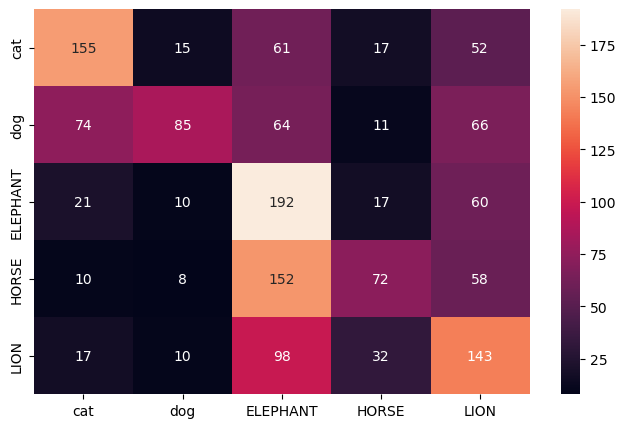

In [97]:
confmat_knn_g = confusion_matrix(y_test, y_val_pred_final_knn_g)
print(classification_report(y_test, y_val_pred_final_knn_g))
plot_confusion_mat(confmat_knn_g , animals)

## LogisticRegression - model

20 iterations: Validation set - Accuracy: 0.463, Training set - Accuracy: 0.467
40 iterations: Validation set - Accuracy: 0.465, Training set - Accuracy: 0.485
60 iterations: Validation set - Accuracy: 0.467, Training set - Accuracy: 0.503
80 iterations: Validation set - Accuracy: 0.469, Training set - Accuracy: 0.516
100 iterations: Validation set - Accuracy: 0.461, Training set - Accuracy: 0.524
120 iterations: Validation set - Accuracy: 0.459, Training set - Accuracy: 0.532
140 iterations: Validation set - Accuracy: 0.461, Training set - Accuracy: 0.543
160 iterations: Validation set - Accuracy: 0.455, Training set - Accuracy: 0.545
180 iterations: Validation set - Accuracy: 0.443, Training set - Accuracy: 0.548
200 iterations: Validation set - Accuracy: 0.441, Training set - Accuracy: 0.551
220 iterations: Validation set - Accuracy: 0.443, Training set - Accuracy: 0.555
240 iterations: Validation set - Accuracy: 0.445, Training set - Accuracy: 0.560
260 iterations: Validation set -

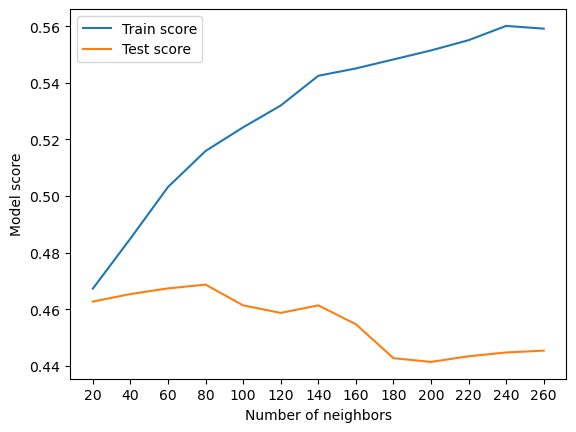

In [98]:
# Usage
best_lr_model , y_val_pred_final = LR(x_train_gray, x_test_gray, y_train_s, y_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.53      0.58      0.55       300
           1       0.58      0.60      0.59       300
           2       0.42      0.45      0.44       300
           3       0.32      0.25      0.28       300
           4       0.44      0.46      0.45       300

    accuracy                           0.47      1500
   macro avg       0.46      0.47      0.46      1500
weighted avg       0.46      0.47      0.46      1500



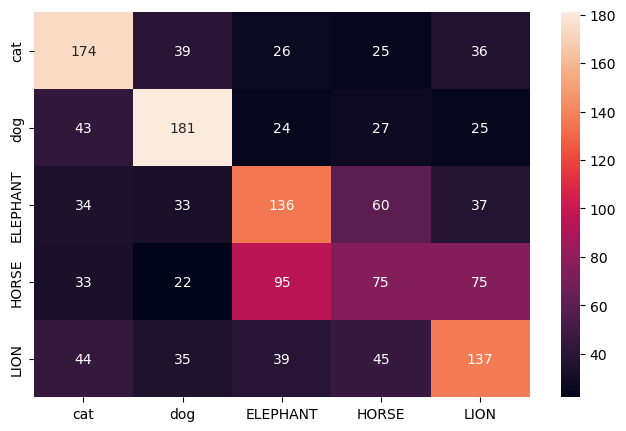

In [99]:
confmat_lr = confusion_matrix(y_test, y_val_pred_final)
print(classification_report(y_test, y_val_pred_final))
plot_confusion_mat(confmat_lr,animals)

## DecisionTree - model

2 iterations: Validation set - Accuracy: 0.295, Training set - Accuracy: 0.306
4 iterations: Validation set - Accuracy: 0.366, Training set - Accuracy: 0.369
6 iterations: Validation set - Accuracy: 0.383, Training set - Accuracy: 0.421
8 iterations: Validation set - Accuracy: 0.403, Training set - Accuracy: 0.510
10 iterations: Validation set - Accuracy: 0.409, Training set - Accuracy: 0.624
12 iterations: Validation set - Accuracy: 0.409, Training set - Accuracy: 0.734
max_depth score on the test data: 40.93%

Best Model (based on Validation Accuracy):
max_depth: 10


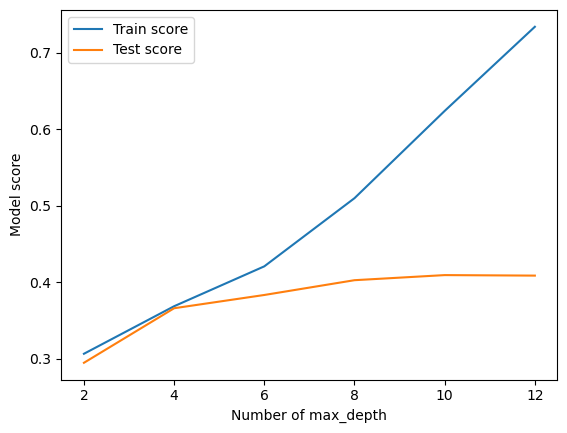

In [102]:
model_dt_pred_g = Decision_tree(x_train_gray,x_test_gray,y_train_s,y_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.47      0.37      0.41       300
           1       0.55      0.44      0.49       300
           2       0.35      0.46      0.40       300
           3       0.38      0.28      0.32       300
           4       0.37      0.50      0.42       300

    accuracy                           0.41      1500
   macro avg       0.42      0.41      0.41      1500
weighted avg       0.42      0.41      0.41      1500



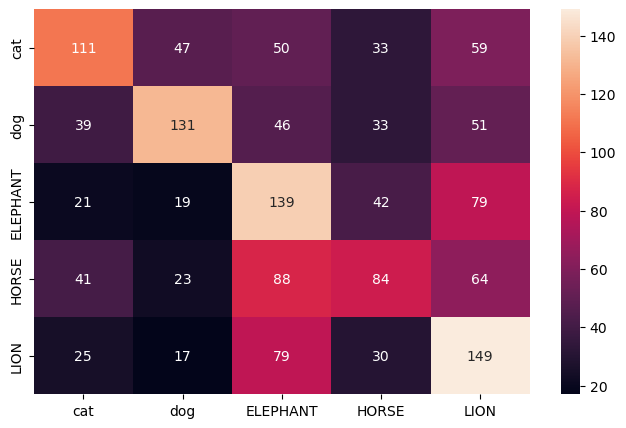

In [110]:
confmat_dt = confusion_matrix(y_test, model_dt_pred_g[1])
plot_confusion_mat(confmat_dt,animals)
print(classification_report(y_test, model_dt_pred_g[1]))


## AdaBoost - model

In [120]:
y_pred_boost = train_and_predict_adaboost(x_train_gray, y_train_s, x_test_gray, y_test)

Accuracy for n_estimators = 10 is: 0.37666666666666665
Accuracy for n_estimators = 20 is: 0.402
Accuracy for n_estimators = 30 is: 0.4093333333333333
Accuracy for n_estimators = 40 is: 0.436
Accuracy for n_estimators = 50 is: 0.44666666666666666
Accuracy for n_estimators = 60 is: 0.4533333333333333
Accuracy for n_estimators = 70 is: 0.45066666666666666
Accuracy for n_estimators = 80 is: 0.4513333333333333
Accuracy for n_estimators = 90 is: 0.4513333333333333
Accuracy for n_estimators = 100 is: 0.46066666666666667
Accuracy for n_estimators = 110 is: 0.4673333333333333
Accuracy for n_estimators = 120 is: 0.46
Accuracy for n_estimators = 130 is: 0.47333333333333333
Accuracy for n_estimators = 140 is: 0.4746666666666667
Accuracy for n_estimators = 150 is: 0.47533333333333333
Accuracy for n_estimators = 160 is: 0.484
Accuracy for n_estimators = 170 is: 0.482
Accuracy for n_estimators = 180 is: 0.474
Accuracy for n_estimators = 190 is: 0.4846666666666667
Accuracy for n_estimators = 200 is: 0

### Confusion matrix

              precision    recall  f1-score   support

         cat       0.56      0.53      0.54       300
         dog       0.60      0.56      0.58       300
    ELEPHANT       0.41      0.46      0.44       300
       HORSE       0.46      0.33      0.38       300
        LION       0.43      0.55      0.48       300

    accuracy                           0.49      1500
   macro avg       0.49      0.49      0.49      1500
weighted avg       0.49      0.49      0.49      1500



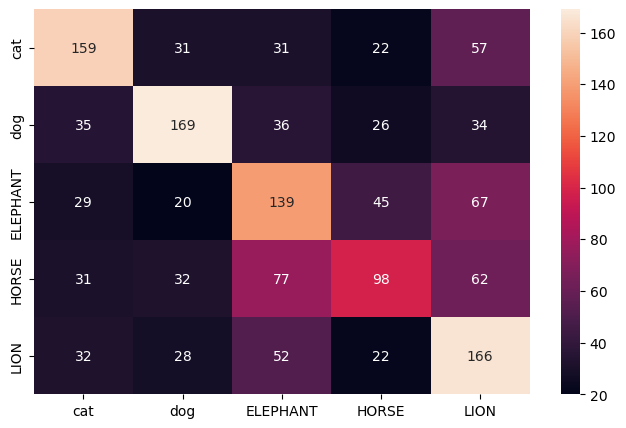

In [121]:
confmat_adaboost = confusion_matrix(y_test, y_pred_boost[1])


# Plot confusion matrix
plot_confusion_mat(confmat_adaboost, animals)

# Print classification report
print(classification_report(y_test, y_pred_boost[1], target_names=animals))

# In summary:

## Model Performance on RGB Images:

* KNN: 45.06%
* Logistic Regression: 59.92%
* Decision Tree: 42.67%
* AdaBoost: 54.4%

## Model Performance on Grayscale Images:

* KNN: 43.13%
* Logistic Regression: 46.87%
* Decision Tree: 40.93%
* AdaBoost: 48.73%

Upon reviewing the results, while Logistic Regression performed the best on color (RGB)
images with an accuracy of 59.92%, it's worth noting that on grayscale images, AdaBoost outperformed other 
algorithms with an accuracy of 48.73%. This indicates that AdaBoost might be better at capturing relevant features
or patterns in grayscale images, contributing to its higher accuracy in this particular scenario.